In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from joblib import dump, load

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [45]:
def make_lognormal_mean(normal_mean, normal_covariance):
    dim = normal_mean.shape[0]
    assert dim >= normal_mean.shape[1]
    assert dim == normal_covariance.shape[0] and dim == normal_covariance.shape[1]
    return np.exp(normal_mean + 0.5*np.diag(normal_covariance).reshape(-1,1))

def make_lognormal_covariance(normal_mean,normal_covariance):
    dim = normal_mean.shape[0]
    assert dim >= normal_mean.shape[1]
    assert dim == normal_covariance.shape[0] and dim == normal_covariance.shape[1]
    cov = np.zeros(shape=(dim,dim))
    cov[:] = np.nan
    for i in range(dim):
        for j in range(dim):
            cov[i,j] = np.exp(normal_mean[i] + normal_mean[j] + 0.5*(normal_covariance[i,i] + normal_covariance[j,j]))*(np.exp(normal_covariance[i,j]) - 1)
    assert np.all(np.isfinite(cov))
    return cov

(25000, 64)


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_1583/2858138271.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cov[i,j] = np.exp(normal_mean[i] + normal_mean[j] + 0.5*(normal_covariance[i,i] + normal_covariance[j,j]))*(np.exp(normal_covariance[i,j]) - 1)
/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_1583/2858138271.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cov[i,j] = np.exp(normal_mean[i] + normal_mean[j] + 0.5*(normal_covariance[i,i] + normal_covariance[j,j]))*(np.exp(normal_covariance[i,j]) - 1)


(64,) (64, 1) (64,) (64, 1)


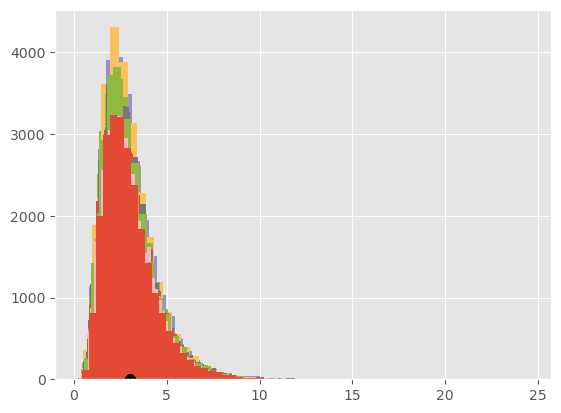

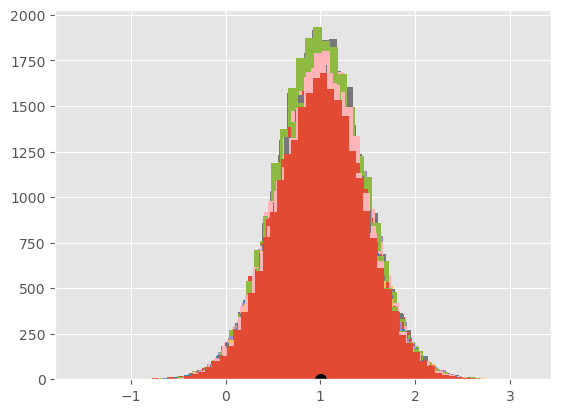

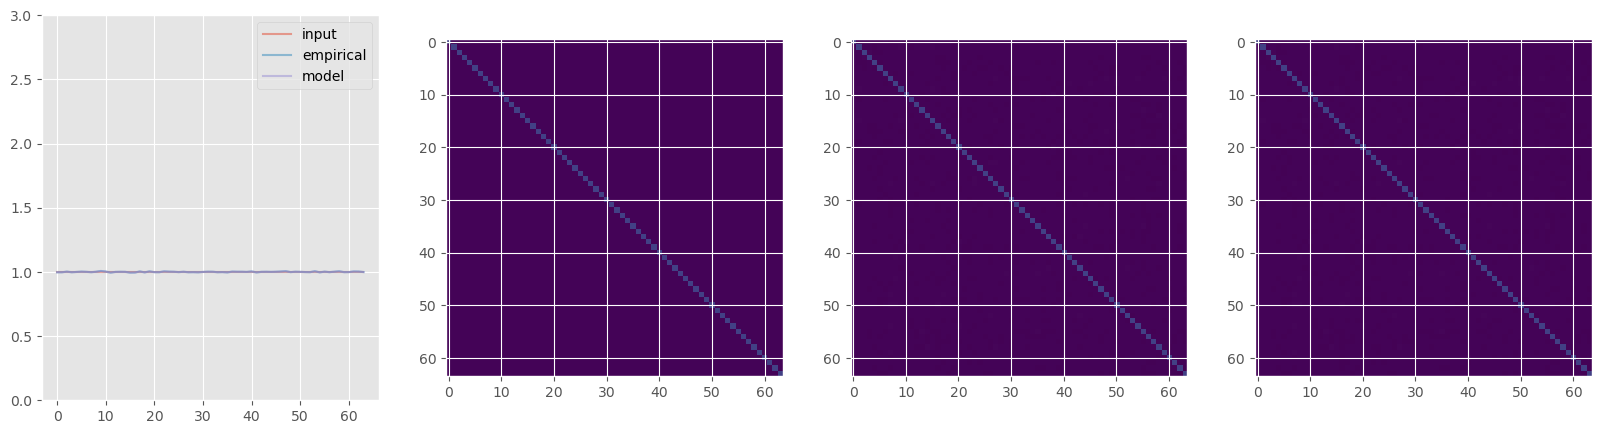

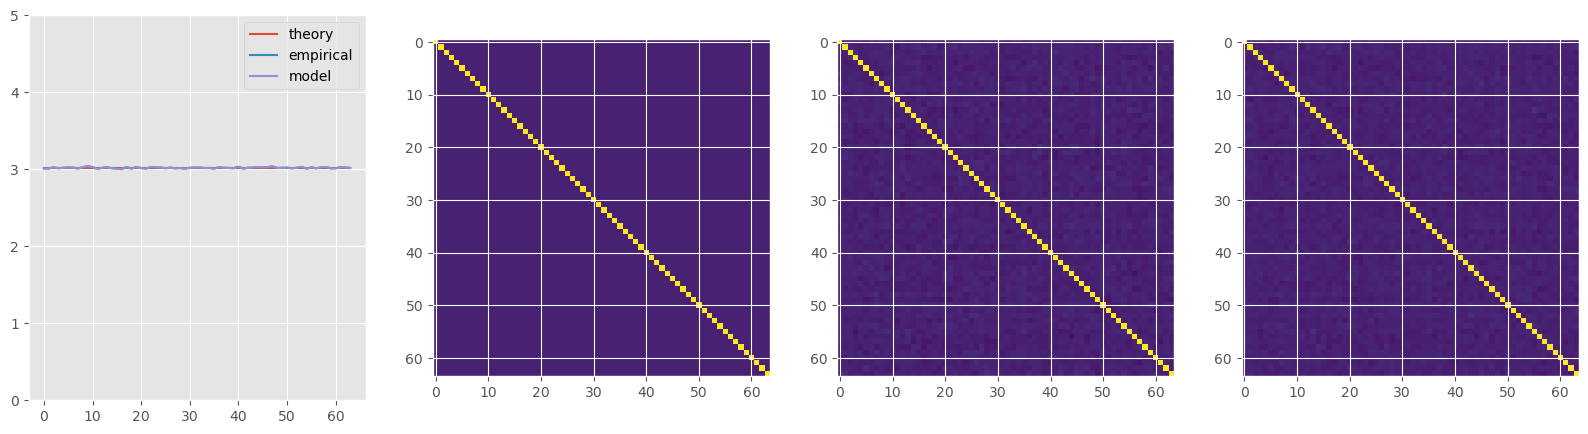

In [122]:
d = np.random.normal(0,1,size=(2,64))

normal_mean = np.ones(shape=(64,1))
normal_cov = np.ones(shape=(64,64))*0.01 + np.eye(64)*0.2

data = np.random.multivariate_normal(normal_mean.reshape(-1),normal_cov,size=(25000))
print(data.shape)

mean_empirical = np.mean(data,axis=0)
cov_empirical = np.cov(data.T)

log_mean_theory = make_lognormal_mean(normal_mean,normal_cov)
log_cov_theory = make_lognormal_covariance(normal_mean,normal_cov)

log_data = np.exp(data)
log_mean_empirical = np.mean(log_data,axis=0)
log_cov_empirical = np.cov(log_data.T)

model = BayesianGaussianMixture(n_components=1,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.e-8,
                                max_iter=200,
                                n_init=3,
                                warm_start=True,
                                random_state=0,
                                )
model.fit(data)

# convert normal moments to lognormal moments (recover lognormal from log'd data)
# this is exponential map from normal to lognormal
log_mean_model = make_lognormal_mean(model.means_[0].reshape(-1,1),model.covariances_[0])
log_cov_model = make_lognormal_covariance(model.means_[0].reshape(-1,1),model.covariances_[0])

plt.figure()
for i, samples in enumerate(log_data.T):
    plt.hist(samples,bins=50)
    plt.plot(log_mean_model[i],[0],'ko')

plt.figure()
for i, samples in enumerate(data.T):
    plt.hist(samples,bins=50)
    plt.plot([model.means_[0,i]],[0],'ko')

print(model.means_[0].shape,log_mean_theory.shape,log_mean_empirical.shape,log_mean_model.shape)

# compare normal data and normal model
normal_fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].plot(normal_mean,alpha=0.5,label="input")
axes[0].plot(mean_empirical,alpha=0.5,label="empirical")
axes[0].plot(model.means_[0],alpha=0.5,label="model")
axes[0].legend()
axes[0].set_ylim([0,3])
axes[1].imshow(normal_cov,vmin=0,vmax=1.1)
axes[2].imshow(cov_empirical,vmin=0,vmax=1.1)
axes[3].imshow(model.covariances_[0],vmin=0,vmax=1.1)

normal_fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].plot(log_mean_theory,label="theory")
axes[0].plot(log_mean_empirical,label="empirical")
axes[0].plot(log_mean_model,label="model")
axes[0].legend()
axes[0].set_ylim([0,5])
axes[1].imshow(log_cov_theory,vmin=0,vmax=1)
axes[2].imshow(log_cov_empirical,vmin=0,vmax=1)
axes[3].imshow(log_cov_model,vmin=0,vmax=1)

In [123]:
gaussians = [np.random.multivariate_normal(np.zeros(shape=(64,)),cov=np.eye(64),size=500),
             np.random.multivariate_normal(10*np.ones(shape=(64,)),cov=np.eye(64),size=500),
             np.random.multivariate_normal(-10*np.ones(shape=(64,)),cov=np.eye(64),size=500)]
samples = np.row_stack(gaussians)

# 64 -> 2 decoder
d = np.random.normal(0,1,(2,64))

model = BayesianGaussianMixture(n_components=3,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.e-8,
                                # init_params="k-means++",
                                max_iter=200,
                                n_init=3,
                                warm_start=True,
                                random_state=0,
                                )
model.fit(samples)

BayesianGaussianMixture(max_iter=200, n_components=3, n_init=3, random_state=0,
                        warm_start=True, weight_concentration_prior=1e-08)

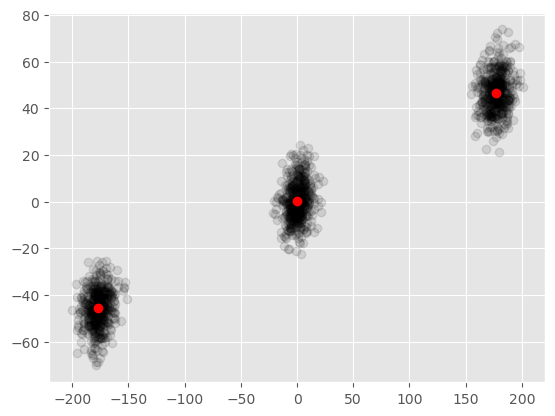

In [124]:
for i,g in enumerate(gaussians):
    s = d @ g.T
    plt.plot(s[0],s[1],'ko',alpha=0.1)
for mean_ in model.means_:
    mean = d @ mean_
    plt.plot(mean[0],mean[1],'ro')